## Perscholas Capstone
### Ndugba, Ogo

In [1]:
# Importing packages
import findspark
findspark.add_packages('mysql:mysql-connector-java:8.0.11')
from pyspark.sql import SparkSession
from pyspark.sql.functions import*
from pyspark.sql.types import*

import ipywidgets as widgets
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import requests
import seaborn as sns
import warnings
warnings.filterwarnings("ignore") 


## Credit Card Data Extraction and creating Spark DataFrames 

In [2]:
#creating sparksession
spark = SparkSession.builder.master("local[*]").appName("Credit_Cards").getOrCreate()

:: loading settings :: url = jar:file:/Users/purple/opt/anaconda3/envs/ps_capstone/lib/python3.10/site-packages/pyspark/jars/ivy-2.5.0.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /Users/purple/.ivy2/cache
The jars for the packages stored in: /Users/purple/.ivy2/jars
mysql#mysql-connector-java added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-8fda87bf-9022-4bbd-aa16-f7ef022d973b;1.0
	confs: [default]
	found mysql#mysql-connector-java;8.0.11 in central
	found com.google.protobuf#protobuf-java;2.6.0 in central
:: resolution report :: resolve 202ms :: artifacts dl 12ms
	:: modules in use:
	com.google.protobuf#protobuf-java;2.6.0 from central in [default]
	mysql#mysql-connector-java;8.0.11 from central in [default]
	---------------------------------------------------------------------
	|                  |            modules            ||   artifacts   |
	|       conf       | number| search|dwnlded|evicted|| number|dwnlded|
	---------------------------------------------------------------------
	|      default     |   2   |   0   |   0   |   0   ||   2   |   0   |
	---------------------------------------

In [3]:
#loading data into dataframes
df_branch = spark.read.json('data/cdw_sapp_branch.json')  
df_credit = spark.read.json('data/cdw_sapp_credit.json') 
df_customers = spark.read.json('data/cdw_sapp_custmer.json')

In [4]:
type(df_branch)

pyspark.sql.dataframe.DataFrame

## Transforming DataFrames

#### Transforming the branch df according to specifications

In [5]:
df_branch.show(5)

+-----------------+-----------+------------+------------+------------+-----------------+----------+--------------------+
|      BRANCH_CITY|BRANCH_CODE| BRANCH_NAME|BRANCH_PHONE|BRANCH_STATE|    BRANCH_STREET|BRANCH_ZIP|        LAST_UPDATED|
+-----------------+-----------+------------+------------+------------+-----------------+----------+--------------------+
|        Lakeville|          1|Example Bank|  1234565276|          MN|     Bridle Court|     55044|2018-04-18T16:51:...|
|          Huntley|          2|Example Bank|  1234618993|          IL|Washington Street|     60142|2018-04-18T16:51:...|
|SouthRichmondHill|          3|Example Bank|  1234985926|          NY|    Warren Street|     11419|2018-04-18T16:51:...|
|       Middleburg|          4|Example Bank|  1234663064|          FL| Cleveland Street|     32068|2018-04-18T16:51:...|
|    KingOfPrussia|          5|Example Bank|  1234849701|          PA|      14th Street|     19406|2018-04-18T16:51:...|
+-----------------+-----------+-

In [6]:
df_branch.columns

['BRANCH_CITY',
 'BRANCH_CODE',
 'BRANCH_NAME',
 'BRANCH_PHONE',
 'BRANCH_STATE',
 'BRANCH_STREET',
 'BRANCH_ZIP',
 'LAST_UPDATED']

In [7]:
df_branch.select('BRANCH_PHONE').show(5)

+------------+
|BRANCH_PHONE|
+------------+
|  1234565276|
|  1234618993|
|  1234985926|
|  1234663064|
|  1234849701|
+------------+
only showing top 5 rows



In [8]:
#transforming the branch df
df_branch = df_branch.withColumn('BRANCH_PHONE', concat(lit('('), col('BRANCH_PHONE')[0:3], lit(')'), 
                                col('BRANCH_PHONE')[4:3], lit('-'), col('BRANCH_PHONE')[7:9]))

df_branch.select('BRANCH_PHONE').show(5)

+-------------+
| BRANCH_PHONE|
+-------------+
|(123)456-5276|
|(123)461-8993|
|(123)498-5926|
|(123)466-3064|
|(123)484-9701|
+-------------+
only showing top 5 rows



In [9]:
#checking for nulls in zip code
df_branch.filter(df_branch.BRANCH_ZIP.isNull()).show()

+-----------+-----------+-----------+------------+------------+-------------+----------+------------+
|BRANCH_CITY|BRANCH_CODE|BRANCH_NAME|BRANCH_PHONE|BRANCH_STATE|BRANCH_STREET|BRANCH_ZIP|LAST_UPDATED|
+-----------+-----------+-----------+------------+------------+-------------+----------+------------+
+-----------+-----------+-----------+------------+------------+-------------+----------+------------+



In [10]:
#there are no nulls in branch zip
print(df_branch.count())
print(df_branch.filter(col('BRANCH_ZIP').isNull()).count())
print(df_branch.filter(col('BRANCH_ZIP').isNotNull()).count())

115
0
115


In [11]:
#completing the requirement in case nulls are later added to file.
df_branch.na.fill(value=99999,subset=['BRANCH_ZIP'])

DataFrame[BRANCH_CITY: string, BRANCH_CODE: bigint, BRANCH_NAME: string, BRANCH_PHONE: string, BRANCH_STATE: string, BRANCH_STREET: string, BRANCH_ZIP: bigint, LAST_UPDATED: string]

#### Transforming the credit df according to specifications

In [12]:
df_credit.show(5)

+-----------+----------------+---------+---+-----+--------------+----------------+-----------------+----+
|BRANCH_CODE|  CREDIT_CARD_NO| CUST_SSN|DAY|MONTH|TRANSACTION_ID|TRANSACTION_TYPE|TRANSACTION_VALUE|YEAR|
+-----------+----------------+---------+---+-----+--------------+----------------+-----------------+----+
|        114|4210653349028689|123459988| 14|    2|             1|       Education|             78.9|2018|
|         35|4210653349028689|123459988| 20|    3|             2|   Entertainment|            14.24|2018|
|        160|4210653349028689|123459988|  8|    7|             3|         Grocery|             56.7|2018|
|        114|4210653349028689|123459988| 19|    4|             4|   Entertainment|            59.73|2018|
|         93|4210653349028689|123459988| 10|   10|             5|             Gas|             3.59|2018|
+-----------+----------------+---------+---+-----+--------------+----------------+-----------------+----+
only showing top 5 rows



In [13]:
df_credit.columns

['BRANCH_CODE',
 'CREDIT_CARD_NO',
 'CUST_SSN',
 'DAY',
 'MONTH',
 'TRANSACTION_ID',
 'TRANSACTION_TYPE',
 'TRANSACTION_VALUE',
 'YEAR']

In [14]:
#transforming credit df
df_credit = df_credit.withColumnRenamed('CREDIT_CARD_NO', 'CUST_CC_NO')
df_credit = df_credit.withColumn('TIMEID', expr('make_date(YEAR, MONTH, DAY)'))
df_credit.show(5)

+-----------+----------------+---------+---+-----+--------------+----------------+-----------------+----+----------+
|BRANCH_CODE|      CUST_CC_NO| CUST_SSN|DAY|MONTH|TRANSACTION_ID|TRANSACTION_TYPE|TRANSACTION_VALUE|YEAR|    TIMEID|
+-----------+----------------+---------+---+-----+--------------+----------------+-----------------+----+----------+
|        114|4210653349028689|123459988| 14|    2|             1|       Education|             78.9|2018|2018-02-14|
|         35|4210653349028689|123459988| 20|    3|             2|   Entertainment|            14.24|2018|2018-03-20|
|        160|4210653349028689|123459988|  8|    7|             3|         Grocery|             56.7|2018|2018-07-08|
|        114|4210653349028689|123459988| 19|    4|             4|   Entertainment|            59.73|2018|2018-04-19|
|         93|4210653349028689|123459988| 10|   10|             5|             Gas|             3.59|2018|2018-10-10|
+-----------+----------------+---------+---+-----+--------------

In [15]:
#creating copy of cleaned_ df credit to use later - need dropped colummns for functions later 
#dropping day, month, and year cols to load to database per mapping doc
df_credit_clean = df_credit
df_credit = df_credit.drop('DAY', 'MONTH', 'YEAR')

#### Transforming the customers df according to specifications

In [16]:
df_customers.select('CUST_PHONE').show(5)

+----------+
|CUST_PHONE|
+----------+
|   1237818|
|   1238933|
|   1243018|
|   1243215|
|   1242074|
+----------+
only showing top 5 rows



In [17]:
#adding the 617 prefix to customers phone number since no area code is specified
df_customers = df_customers.withColumn('CUST_PHONE', concat(lit('(617)'), col('CUST_PHONE')[1:3], 
                                        lit('-'), col('CUST_PHONE')[4:8] ))
df_customers.select('CUST_PHONE').show(5)

+-------------+
|   CUST_PHONE|
+-------------+
|(617)123-7818|
|(617)123-8933|
|(617)124-3018|
|(617)124-3215|
|(617)124-2074|
+-------------+
only showing top 5 rows



In [18]:
df_customers.columns

['APT_NO',
 'CREDIT_CARD_NO',
 'CUST_CITY',
 'CUST_COUNTRY',
 'CUST_EMAIL',
 'CUST_PHONE',
 'CUST_STATE',
 'CUST_ZIP',
 'FIRST_NAME',
 'LAST_NAME',
 'LAST_UPDATED',
 'MIDDLE_NAME',
 'SSN',
 'STREET_NAME']

In [19]:
#transforming the customer df
df_customers = df_customers.withColumn('FIRST_NAME', initcap(df_customers['FIRST_NAME']))
df_customers = df_customers.withColumn('MIDDLE_NAME', lower(df_customers['MIDDLE_NAME']))
df_customers = df_customers.withColumn('LAST_NAME', initcap(df_customers['LAST_NAME']))
df_customers = df_customers.withColumnRenamed('CREDIT_CARD_NO', 'Credit_card_no')
df_customers = df_customers.withColumn('FULL_STREET_ADDRESS', concat(col('APT_NO'),lit(','),col('STREET_NAME')))
df_customers.show(5)


+------+----------------+------------+-------------+-------------------+-------------+----------+--------+----------+---------+--------------------+-----------+---------+-----------------+--------------------+
|APT_NO|  Credit_card_no|   CUST_CITY| CUST_COUNTRY|         CUST_EMAIL|   CUST_PHONE|CUST_STATE|CUST_ZIP|FIRST_NAME|LAST_NAME|        LAST_UPDATED|MIDDLE_NAME|      SSN|      STREET_NAME| FULL_STREET_ADDRESS|
+------+----------------+------------+-------------+-------------------+-------------+----------+--------+----------+---------+--------------------+-----------+---------+-----------------+--------------------+
|   656|4210653310061055|     Natchez|United States|AHooper@example.com|(617)123-7818|        MS|   39120|      Alec|   Hooper|2018-04-21T12:49:...|         wm|123456100|Main Street North|656,Main Street N...|
|   829|4210653310102868|Wethersfield|United States|EHolman@example.com|(617)123-8933|        CT|   06109|      Etta|   Holman|2018-04-21T12:49:...|    brendan|

In [20]:
#creating copy of cleaned_ df customer to use later - need dropped colummns for functions later 
#dropping address and apt cols to load to database per mapping doc
df_customers_clean = df_customers
df_customers = df_customers.drop('APT_NO', 'STREET_NAME')
df_customers.columns

['Credit_card_no',
 'CUST_CITY',
 'CUST_COUNTRY',
 'CUST_EMAIL',
 'CUST_PHONE',
 'CUST_STATE',
 'CUST_ZIP',
 'FIRST_NAME',
 'LAST_NAME',
 'LAST_UPDATED',
 'MIDDLE_NAME',
 'SSN',
 'FULL_STREET_ADDRESS']

In [21]:
print(df_branch.show(5))
print(df_credit.show(5))
print(df_customers.show(5))

+-----------------+-----------+------------+-------------+------------+-----------------+----------+--------------------+
|      BRANCH_CITY|BRANCH_CODE| BRANCH_NAME| BRANCH_PHONE|BRANCH_STATE|    BRANCH_STREET|BRANCH_ZIP|        LAST_UPDATED|
+-----------------+-----------+------------+-------------+------------+-----------------+----------+--------------------+
|        Lakeville|          1|Example Bank|(123)456-5276|          MN|     Bridle Court|     55044|2018-04-18T16:51:...|
|          Huntley|          2|Example Bank|(123)461-8993|          IL|Washington Street|     60142|2018-04-18T16:51:...|
|SouthRichmondHill|          3|Example Bank|(123)498-5926|          NY|    Warren Street|     11419|2018-04-18T16:51:...|
|       Middleburg|          4|Example Bank|(123)466-3064|          FL| Cleveland Street|     32068|2018-04-18T16:51:...|
|    KingOfPrussia|          5|Example Bank|(123)484-9701|          PA|      14th Street|     19406|2018-04-18T16:51:...|
+-----------------+-----

In [22]:
#checking col names
df_branch.printSchema()

root
 |-- BRANCH_CITY: string (nullable = true)
 |-- BRANCH_CODE: long (nullable = true)
 |-- BRANCH_NAME: string (nullable = true)
 |-- BRANCH_PHONE: string (nullable = true)
 |-- BRANCH_STATE: string (nullable = true)
 |-- BRANCH_STREET: string (nullable = true)
 |-- BRANCH_ZIP: long (nullable = true)
 |-- LAST_UPDATED: string (nullable = true)



In [23]:
#checking col names
df_credit.printSchema()

root
 |-- BRANCH_CODE: long (nullable = true)
 |-- CUST_CC_NO: string (nullable = true)
 |-- CUST_SSN: long (nullable = true)
 |-- TRANSACTION_ID: long (nullable = true)
 |-- TRANSACTION_TYPE: string (nullable = true)
 |-- TRANSACTION_VALUE: double (nullable = true)
 |-- TIMEID: date (nullable = true)



In [24]:
#checking col names
df_customers.printSchema()

root
 |-- Credit_card_no: string (nullable = true)
 |-- CUST_CITY: string (nullable = true)
 |-- CUST_COUNTRY: string (nullable = true)
 |-- CUST_EMAIL: string (nullable = true)
 |-- CUST_PHONE: string (nullable = true)
 |-- CUST_STATE: string (nullable = true)
 |-- CUST_ZIP: string (nullable = true)
 |-- FIRST_NAME: string (nullable = true)
 |-- LAST_NAME: string (nullable = true)
 |-- LAST_UPDATED: string (nullable = true)
 |-- MIDDLE_NAME: string (nullable = true)
 |-- SSN: long (nullable = true)
 |-- FULL_STREET_ADDRESS: string (nullable = true)



#### Loading cleaned tables into MySQL Database

In [25]:
df_branch.write.format("jdbc") \
  .mode("overwrite") \
  .option("driver", "com.mysql.cj.jdbc.Driver")\
  .option("url", "jdbc:mysql://localhost:3306/creditcard_capstone") \
  .option("dbtable", "creditcard_capstone.CDW_SAPP_BRANCH") \
  .option("user", "root") \
  .option("password", "pass1234") \
  .save()

Thu Mar 02 14:51:03 EST 2023 WARN: Establishing SSL connection without server's identity verification is not recommended. According to MySQL 5.5.45+, 5.6.26+ and 5.7.6+ requirements SSL connection must be established by default if explicit option isn't set. For compliance with existing applications not using SSL the verifyServerCertificate property is set to 'false'. You need either to explicitly disable SSL by setting useSSL=false, or set useSSL=true and provide truststore for server certificate verification.
Thu Mar 02 14:51:04 EST 2023 WARN: Establishing SSL connection without server's identity verification is not recommended. According to MySQL 5.5.45+, 5.6.26+ and 5.7.6+ requirements SSL connection must be established by default if explicit option isn't set. For compliance with existing applications not using SSL the verifyServerCertificate property is set to 'false'. You need either to explicitly disable SSL by setting useSSL=false, or set useSSL=true and provide truststore for s

In [26]:
df_credit.write.format("jdbc") \
  .mode("overwrite") \
  .option("driver", "com.mysql.cj.jdbc.Driver")\
  .option("url", "jdbc:mysql://localhost:3306/creditcard_capstone") \
  .option("dbtable", "creditcard_capstone.CDW_SAPP_CREDIT_CARD") \
  .option("user", "root") \
  .option("password", "pass1234") \
  .save()

Thu Mar 02 14:51:04 EST 2023 WARN: Establishing SSL connection without server's identity verification is not recommended. According to MySQL 5.5.45+, 5.6.26+ and 5.7.6+ requirements SSL connection must be established by default if explicit option isn't set. For compliance with existing applications not using SSL the verifyServerCertificate property is set to 'false'. You need either to explicitly disable SSL by setting useSSL=false, or set useSSL=true and provide truststore for server certificate verification.
Thu Mar 02 14:51:05 EST 2023 WARN: Establishing SSL connection without server's identity verification is not recommended. According to MySQL 5.5.45+, 5.6.26+ and 5.7.6+ requirements SSL connection must be established by default if explicit option isn't set. For compliance with existing applications not using SSL the verifyServerCertificate property is set to 'false'. You need either to explicitly disable SSL by setting useSSL=false, or set useSSL=true and provide truststore for s

In [27]:
df_customers.write.format("jdbc") \
  .mode("overwrite") \
  .option("driver", "com.mysql.cj.jdbc.Driver")\
  .option("url", "jdbc:mysql://localhost:3306/creditcard_capstone") \
  .option("dbtable", "creditcard_capstone.CDW_SAPP_CUSTOMER") \
  .option("user", "root") \
  .option("password", "pass1234") \
  .save()

Thu Mar 02 14:51:08 EST 2023 WARN: Establishing SSL connection without server's identity verification is not recommended. According to MySQL 5.5.45+, 5.6.26+ and 5.7.6+ requirements SSL connection must be established by default if explicit option isn't set. For compliance with existing applications not using SSL the verifyServerCertificate property is set to 'false'. You need either to explicitly disable SSL by setting useSSL=false, or set useSSL=true and provide truststore for server certificate verification.
Thu Mar 02 14:51:08 EST 2023 WARN: Establishing SSL connection without server's identity verification is not recommended. According to MySQL 5.5.45+, 5.6.26+ and 5.7.6+ requirements SSL connection must be established by default if explicit option isn't set. For compliance with existing applications not using SSL the verifyServerCertificate property is set to 'false'. You need either to explicitly disable SSL by setting useSSL=false, or set useSSL=true and provide truststore for s

## Data Wrangling


In [28]:
#recalling data from above
#changing clean dataframes back to original names
df_credit = df_credit_clean
df_customers = df_customers_clean
df_branch.show(5)
df_credit_clean.show(5)
df_customers_clean.show(5)

+-----------------+-----------+------------+-------------+------------+-----------------+----------+--------------------+
|      BRANCH_CITY|BRANCH_CODE| BRANCH_NAME| BRANCH_PHONE|BRANCH_STATE|    BRANCH_STREET|BRANCH_ZIP|        LAST_UPDATED|
+-----------------+-----------+------------+-------------+------------+-----------------+----------+--------------------+
|        Lakeville|          1|Example Bank|(123)456-5276|          MN|     Bridle Court|     55044|2018-04-18T16:51:...|
|          Huntley|          2|Example Bank|(123)461-8993|          IL|Washington Street|     60142|2018-04-18T16:51:...|
|SouthRichmondHill|          3|Example Bank|(123)498-5926|          NY|    Warren Street|     11419|2018-04-18T16:51:...|
|       Middleburg|          4|Example Bank|(123)466-3064|          FL| Cleveland Street|     32068|2018-04-18T16:51:...|
|    KingOfPrussia|          5|Example Bank|(123)484-9701|          PA|      14th Street|     19406|2018-04-18T16:51:...|
+-----------------+-----

In [29]:
#creating new table for analysis on customer and credit data
df_cust_and_credit = df_credit.join(df_customers, df_credit.CUST_SSN == df_customers.SSN,"outer")
df_cust_and_credit.printSchema()

root
 |-- BRANCH_CODE: long (nullable = true)
 |-- CUST_CC_NO: string (nullable = true)
 |-- CUST_SSN: long (nullable = true)
 |-- DAY: long (nullable = true)
 |-- MONTH: long (nullable = true)
 |-- TRANSACTION_ID: long (nullable = true)
 |-- TRANSACTION_TYPE: string (nullable = true)
 |-- TRANSACTION_VALUE: double (nullable = true)
 |-- YEAR: long (nullable = true)
 |-- TIMEID: date (nullable = true)
 |-- APT_NO: string (nullable = true)
 |-- Credit_card_no: string (nullable = true)
 |-- CUST_CITY: string (nullable = true)
 |-- CUST_COUNTRY: string (nullable = true)
 |-- CUST_EMAIL: string (nullable = true)
 |-- CUST_PHONE: string (nullable = true)
 |-- CUST_STATE: string (nullable = true)
 |-- CUST_ZIP: string (nullable = true)
 |-- FIRST_NAME: string (nullable = true)
 |-- LAST_NAME: string (nullable = true)
 |-- LAST_UPDATED: string (nullable = true)
 |-- MIDDLE_NAME: string (nullable = true)
 |-- SSN: long (nullable = true)
 |-- STREET_NAME: string (nullable = true)
 |-- FULL_STRE

In [30]:
#creating new table for analysis on branch and credit data
#changing BRANCH_CODE name - to avoid ambigous column error when querying
df_branch = df_branch.withColumnRenamed('BRANCH_CODE','BRANCHCODE') 
df_branch_and_credit = df_credit.join(df_branch, df_credit.BRANCH_CODE == df_branch.BRANCHCODE, "outer")
df_branch_and_credit.printSchema()

root
 |-- BRANCH_CODE: long (nullable = true)
 |-- CUST_CC_NO: string (nullable = true)
 |-- CUST_SSN: long (nullable = true)
 |-- DAY: long (nullable = true)
 |-- MONTH: long (nullable = true)
 |-- TRANSACTION_ID: long (nullable = true)
 |-- TRANSACTION_TYPE: string (nullable = true)
 |-- TRANSACTION_VALUE: double (nullable = true)
 |-- YEAR: long (nullable = true)
 |-- TIMEID: date (nullable = true)
 |-- BRANCH_CITY: string (nullable = true)
 |-- BRANCHCODE: long (nullable = true)
 |-- BRANCH_NAME: string (nullable = true)
 |-- BRANCH_PHONE: string (nullable = true)
 |-- BRANCH_STATE: string (nullable = true)
 |-- BRANCH_STREET: string (nullable = true)
 |-- BRANCH_ZIP: long (nullable = true)
 |-- LAST_UPDATED: string (nullable = true)



In [31]:
#dropped cols to be able to check for nulls - 
df_cust_and_credit = df_cust_and_credit.drop('TIMEID')
df_cust_and_credit = df_cust_and_credit.drop('LAST_UPDATED')
df_branch_and_credit = df_branch_and_credit.drop('BRANCHCODE')

In [32]:
#checking for nulls
df_cust_and_credit.select([count(when(isnan(c), c)).alias(c) for c in df_cust_and_credit.columns]).show()

+-----------+----------+--------+---+-----+--------------+----------------+-----------------+----+------+--------------+---------+------------+----------+----------+----------+--------+----------+---------+-----------+---+-----------+-------------------+
|BRANCH_CODE|CUST_CC_NO|CUST_SSN|DAY|MONTH|TRANSACTION_ID|TRANSACTION_TYPE|TRANSACTION_VALUE|YEAR|APT_NO|Credit_card_no|CUST_CITY|CUST_COUNTRY|CUST_EMAIL|CUST_PHONE|CUST_STATE|CUST_ZIP|FIRST_NAME|LAST_NAME|MIDDLE_NAME|SSN|STREET_NAME|FULL_STREET_ADDRESS|
+-----------+----------+--------+---+-----+--------------+----------------+-----------------+----+------+--------------+---------+------------+----------+----------+----------+--------+----------+---------+-----------+---+-----------+-------------------+
|          0|         0|       0|  0|    0|             0|               0|                0|   0|     0|             0|        0|           0|         0|         0|         0|       0|         0|        0|          0|  0|          0| 

In [33]:
df_cust_and_credit.select([count(when(col(c).isNull(), c)).alias(c) for c in df_cust_and_credit.columns]).show()

+-----------+----------+--------+---+-----+--------------+----------------+-----------------+----+------+--------------+---------+------------+----------+----------+----------+--------+----------+---------+-----------+---+-----------+-------------------+
|BRANCH_CODE|CUST_CC_NO|CUST_SSN|DAY|MONTH|TRANSACTION_ID|TRANSACTION_TYPE|TRANSACTION_VALUE|YEAR|APT_NO|Credit_card_no|CUST_CITY|CUST_COUNTRY|CUST_EMAIL|CUST_PHONE|CUST_STATE|CUST_ZIP|FIRST_NAME|LAST_NAME|MIDDLE_NAME|SSN|STREET_NAME|FULL_STREET_ADDRESS|
+-----------+----------+--------+---+-----+--------------+----------------+-----------------+----+------+--------------+---------+------------+----------+----------+----------+--------+----------+---------+-----------+---+-----------+-------------------+
|          0|         0|       0|  0|    0|             0|               0|                0|   0|     0|             0|        0|           0|         0|         0|         0|       0|         0|        0|          0|  0|          0| 

In [34]:
#recreating dataframes with cols that were dropped to check for nulls
df_cust_and_credit = df_credit.join(df_customers, df_credit.CUST_SSN == df_customers.SSN,"outer")
df_branch = df_branch.withColumnRenamed('BRANCH_CODE','BRANCHCODE') 
df_branch_and_credit = df_credit.join(df_branch, df_credit.BRANCH_CODE == df_branch.BRANCHCODE, "outer")

In [35]:
#creating pandas dataframes to use
pd_branch = df_branch.toPandas()
pd_credit = df_credit.toPandas()
pd_customers = df_customers.toPandas()
pd_branch_and_credit = df_branch_and_credit.toPandas()
pd_cust_and_credit = df_cust_and_credit.toPandas()

In [36]:
#year is 2018 - not including in dropdown, can modify at a later date if new data is added from another year
pd_cust_and_credit['YEAR'].value_counts()

2018    46694
Name: YEAR, dtype: int64

In [37]:
#creating views to use in creating functions
df_branch.createOrReplaceTempView("branch")
df_credit.createOrReplaceTempView("credit")
df_customers.createOrReplaceTempView("customers")
df_cust_and_credit.createOrReplaceTempView("cc")
df_branch_and_credit.createOrReplaceTempView("bcr")

## Widget to display transactions by zipcode, and month 

In [38]:
#creating new dataframe for dropdown widget
#dropping cols for widget use
data_for_dropdown = pd_cust_and_credit
data_for_dropdown = data_for_dropdown.drop(['CUST_CC_NO','CUST_EMAIL','TIMEID','TRANSACTION_ID',
                'Credit_card_no', 'CUST_PHONE', 'LAST_UPDATED', 'CUST_CITY','CUST_COUNTRY'], axis=1)

In [39]:
#function from 
#https://towardsdatascience.com/bring-your-jupyter-notebook-to-life-with-interactive-widgets-bc12e03f0916
ALL = 'ALL'
def unique_sorted_values_plus_ALL(array):
    unique = array.unique().tolist()
    unique.sort()
    unique.insert(0, ALL)
    return unique

In [40]:
#dropdownmenu - need to choose month and zipcode to display output in next cell
output = widgets.Output()

dropdown_zipcode = widgets.Dropdown(options = unique_sorted_values_plus_ALL(data_for_dropdown.CUST_ZIP))
dropdown_month = widgets.Dropdown(options = unique_sorted_values_plus_ALL(data_for_dropdown.MONTH))

def common_filtering(month, zipcode):
    output.clear_output()
    
    if (month == ALL) & (zipcode == ALL):
        common_filter = data_for_dropdown
    elif (month == ALL):
        common_filter = data_for_dropdown[data_for_dropdown.CUST_ZIP == zipcode]
    elif (zipcode == ALL):
        common_filter = data_for_dropdown[data_for_dropdown.MONTH == month]
    else:
        common_filter = data_for_dropdown[(data_for_dropdown.MONTH == month) & 
                                  (data_for_dropdown.CUST_ZIP == zipcode)]
    
    with output:
        display(common_filter)
        
        
def dropdown_month_eventhandler(change):
    common_filtering(change.new, dropdown_zipcode.value)
    
def dropdown_zipcode_eventhandler(change):
    common_filtering(dropdown_month.value, change.new)

dropdown_month.observe(dropdown_month_eventhandler, names='value')
dropdown_zipcode.observe(dropdown_zipcode_eventhandler, names='value')



display(dropdown_zipcode)
display(dropdown_month)

Dropdown(options=('ALL', '01810', '02127', '02155', '02169', '02780', '06109', '06511', '07111', '07501', '076…

Dropdown(options=('ALL', 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12), value='ALL')

In [41]:
display(output)

Output(outputs=({'output_type': 'display_data', 'data': {'text/plain': '       BRANCH_CODE   CUST_SSN  DAY  MO…

## Function to display transactions by zipcode, and month 

In [42]:
#Use   22180, 2018, 5
zipcode = input("Please enter your 5 digit zipcode: " )
year = input("Please enter your 4 digit year: " )
month = input("Please choose a month from 1 through 12: " )

def get_transactions_by_zipcode(zipcode, year, month):
    results = spark.sql("SELECT cc.LAST_NAME, cc.FIRST_NAME, cc.CUST_ZIP, cc.YEAR, cc.MONTH, cc.DAY \
            FROM cc \
            WHERE cc.CUST_ZIP = '{}' AND cc.YEAR = '{}' AND cc.MONTH = '{}' \
            ORDER BY cc.DAY DESC".format(str(zipcode), str(year), str(month)))

    results.show(1000)

get_transactions_by_zipcode(zipcode, year, month)


Please enter your 5 digit zipcode: 22180
Please enter your 4 digit year: 2018
Please choose a month from 1 through 12: 5
+---------+----------+--------+----+-----+---+
|LAST_NAME|FIRST_NAME|CUST_ZIP|YEAR|MONTH|DAY|
+---------+----------+--------+----+-----+---+
|   Spence|      Fred|   22180|2018|    5| 28|
|   Savage|     Clara|   22180|2018|    5| 26|
|  Salinas|     Keven|   22180|2018|    5| 24|
|     Kemp|    Sheila|   22180|2018|    5| 23|
|  Conklin|  Harrison|   22180|2018|    5| 23|
|   Savage|     Clara|   22180|2018|    5| 22|
|   Spence|      Fred|   22180|2018|    5| 22|
|      Poe|    Leslie|   22180|2018|    5| 21|
|   Ramsey|      Omar|   22180|2018|    5| 21|
|  Conklin|  Harrison|   22180|2018|    5| 19|
|   Savage|     Clara|   22180|2018|    5| 18|
|   Krause|    Nannie|   22180|2018|    5| 18|
|  Conklin|  Harrison|   22180|2018|    5| 17|
|  Salinas|     Keven|   22180|2018|    5| 17|
|     Kemp|    Sheila|   22180|2018|    5| 16|
|   Spence|      Fred|   22180|20

## Function to display total number of transaction by transaction type

In [43]:
transaction_type = input("Please choose transaction type from the following - Education, Entertainment\
  Healthcare, Grocery, Test, Gas, Bills: " )

def get_transaction_by_type(transaction_type):
    transactions = spark.sql("SELECT TRANSACTION_TYPE, COUNT(*) AS num_transactions, ROUND(SUM(TRANSACTION_VALUE),2) AS total_value \
                               FROM credit \
                               WHERE TRANSACTION_TYPE = '{}' \
                               GROUP BY TRANSACTION_TYPE".format(transaction_type))
    transactions.show()
    
get_transaction_by_type(transaction_type)

Please choose transaction type from the following - Education, Entertainment  Healthcare, Grocery, Test, Gas, Bills: Education
+----------------+----------------+-----------+
|TRANSACTION_TYPE|num_transactions|total_value|
+----------------+----------------+-----------+
|       Education|            6638|  337980.07|
+----------------+----------------+-----------+



## Function to display total number of transaction by branch location

In [44]:
state_name = input("Please choose a state from the following list (NY, GA, PA, FL, IL, MI, MD, NJ, CA, OH, \
 NC, VA, MA, TX, WI, SC, MN, MS, KY, WA, IA, CT, IN, MT, AR, AL): " )

def transactions_by_state(state_name):
    trans_by_state = spark.sql("SELECT BRANCH_CODE, COUNT(*) AS num_transactions, ROUND(SUM(TRANSACTION_VALUE),2) AS total_value \
                               FROM bcr \
                               WHERE BRANCH_STATE = '{}' \
                               GROUP BY BRANCH_CODE".format(state_name))
    trans_by_state.show(100)
    
transactions_by_state(state_name)

Please choose a state from the following list (NY, GA, PA, FL, IL, MI, MD, NJ, CA, OH,  NC, VA, MA, TX, WI, SC, MN, MS, KY, WA, IA, CT, IN, MT, AR, AL): GA
+-----------+----------------+-----------+
|BRANCH_CODE|num_transactions|total_value|
+-----------+----------------+-----------+
|         31|             429|   21748.68|
|       null|               1|       null|
|         58|             399|   19677.29|
|         35|             382|   18588.04|
|        166|             379|   19807.47|
|         40|             434|   22895.51|
+-----------+----------------+-----------+



In [45]:
state = input("Please choose a state from the following list (NY, GA, PA, FL, IL, MI, MD, NJ, CA, OH,\
NC, VA, MA, TX, WI, SC, MN, MS, KY, WA, IA, CT, IN, MT, AR, AL): ")

def get_branch_transaction_info(state):
    trans_by_branch_state = spark.sql(f"SELECT COUNT(bcr.BRANCH_STATE) as Branches_in_{state}, \
    ROUND(SUM(bcr.TRANSACTION_VALUE),2) as Total_Transactions_Value \
    FROM bcr \
    WHERE bcr.BRANCH_STATE = '{state}'")
    trans_by_branch_state.show()

get_branch_transaction_info(state)


Please choose a state from the following list (NY, GA, PA, FL, IL, MI, MD, NJ, CA, OH,NC, VA, MA, TX, WI, SC, MN, MS, KY, WA, IA, CT, IN, MT, AR, AL): GA
+--------------+------------------------+
|Branches_in_GA|Total_Transactions_Value|
+--------------+------------------------+
|          2024|               102716.99|
+--------------+------------------------+



## Function to display user information

In [46]:
#Use 123459988
customer_ssn = input("Please enter your social security number: ")

def get_customer_information(customer_ssn):
    customer_info = spark.sql("SELECT * \
    FROM customers \
    WHERE customers.SSN = '{}'".format(customer_ssn))
    customer_info.show()

get_customer_information(customer_ssn)


Please enter your social security number: 123459988
+------+----------------+------------+-------------+-------------------+-------------+----------+--------+----------+---------+--------------------+-----------+---------+------------+-------------------+
|APT_NO|  Credit_card_no|   CUST_CITY| CUST_COUNTRY|         CUST_EMAIL|   CUST_PHONE|CUST_STATE|CUST_ZIP|FIRST_NAME|LAST_NAME|        LAST_UPDATED|MIDDLE_NAME|      SSN| STREET_NAME|FULL_STREET_ADDRESS|
+------+----------------+------------+-------------+-------------------+-------------+----------+--------+----------+---------+--------------------+-----------+---------+------------+-------------------+
|   774|4210653349028689|Harleysville|United States|ACampos@example.com|(617)123-6163|        PA|   19438|    Amalia|   Campos|2018-04-21T12:49:...|        hal|123459988|Valley Drive|   774,Valley Drive|
+------+----------------+------------+-------------+-------------------+-------------+----------+--------+----------+---------+-----

## Function to modify user information

In [47]:
#Use 123456100
ssn = input("Please enter your social security number: ")
field = input("Please enter in the field you would like to change (Credit_card_no, CUST_CITY, CUST_COUNTRY, \
 CUST_EMAIL, CUST_PHONE, CUST_STATE, CUST_ZIP, FIRST_NAME, LAST_NAME, MIDDLE_NAME, SSN): ")
new_value = input("Please enter the changed information: ")


def update_customer_info(ssn, field, new_value):
    customers_fun = df_customers
    if field in ['CUST_PHONE', 'SSN']:
        customers_fun = customers_fun.withColumn(field, when(customers_fun.SSN == ssn, new_value).otherwise(customers_fun[field]))
        customers_fun = customers_fun.withColumn('lastUpdated', current_timestamp())
    else:
        customers_fun = customers_fun.withColumn(field, when(customers_fun.SSN == ssn, new_value).otherwise(customers_fun[field]))
        customers_fun = customers_fun.withColumn('lastUpdated', current_timestamp())
    customers_fun.write.mode("overwrite").saveAsTable("customers")

    customers_fun.show(100)
    return customers_fun

update_customer_info(ssn, field, new_value)

Please enter your social security number: 123456100
Please enter in the field you would like to change (Credit_card_no, CUST_CITY, CUST_COUNTRY,  CUST_EMAIL, CUST_PHONE, CUST_STATE, CUST_ZIP, FIRST_NAME, LAST_NAME, MIDDLE_NAME, SSN): CUST_ZIP
Please enter the changed information: 99999


+------+----------------+-----------------+-------------+--------------------+-------------+----------+--------+----------+----------+--------------------+-----------+---------+-----------------+--------------------+--------------------+
|APT_NO|  Credit_card_no|        CUST_CITY| CUST_COUNTRY|          CUST_EMAIL|   CUST_PHONE|CUST_STATE|CUST_ZIP|FIRST_NAME| LAST_NAME|        LAST_UPDATED|MIDDLE_NAME|      SSN|      STREET_NAME| FULL_STREET_ADDRESS|         lastUpdated|
+------+----------------+-----------------+-------------+--------------------+-------------+----------+--------+----------+----------+--------------------+-----------+---------+-----------------+--------------------+--------------------+
|   656|4210653310061055|          Natchez|United States| AHooper@example.com|(617)123-7818|        MS|   99999|      Alec|    Hooper|2018-04-21T12:49:...|         wm|123456100|Main Street North|656,Main Street N...|2023-03-02 14:52:...|
|   829|4210653310102868|     Wethersfield|Unite

DataFrame[APT_NO: string, Credit_card_no: string, CUST_CITY: string, CUST_COUNTRY: string, CUST_EMAIL: string, CUST_PHONE: string, CUST_STATE: string, CUST_ZIP: string, FIRST_NAME: string, LAST_NAME: string, LAST_UPDATED: string, MIDDLE_NAME: string, SSN: bigint, STREET_NAME: string, FULL_STREET_ADDRESS: string, lastUpdated: timestamp]

## Function to generate monthly credit card bill for customer

In [48]:
#Use  4210653349028689,  2  2018
cc_number = input("Please enter your credit card number: ")
year = input("Please enter the year you would like to view the bill for: ")
month = input("Please enter the month you would like to view the bill for: ")

def get_customer_bill(cc_number, year, month):
    customer_bill = spark.sql("SELECT cc.FIRST_NAME, cc.LAST_NAME, cc.CUST_SSN, \
    ROUND(SUM(TRANSACTION_VALUE), 2) AS MONTHLY_BILL \
    FROM cc \
    WHERE cc.CUST_CC_NO = '{}' AND cc.YEAR = {} AND cc.MONTH = {} \
    GROUP BY cc.CUST_SSN, cc.FIRST_NAME, cc.LAST_NAME".format(str(cc_number), str(year), str(month)))
    customer_bill.show()
    

get_customer_bill(cc_number, year, month)


Please enter your credit card number: 4210653349028689
Please enter the year you would like to view the bill for: 2018
Please enter the month you would like to view the bill for: 2
+----------+---------+---------+------------+
|FIRST_NAME|LAST_NAME| CUST_SSN|MONTHLY_BILL|
+----------+---------+---------+------------+
|    Amalia|   Campos|123459988|      358.91|
+----------+---------+---------+------------+



## Function to display transactions by customer for a given time period

In [49]:
#Use 123452490 2018-01-01 2018-12-31

ssn = input("Please enter your social security number: ")
start_date = input("Please enter your transaction start date as (YYYY-MM-DD): ")
end_date = input("Please enter your transaction end date as (YYYY-MM-DD): ")

def get_customer_transactions(ssn, start_date, end_date): 
    customer_transactions = spark.sql("SELECT cc.FIRST_NAME, cc.LAST_NAME, cc.TRANSACTION_VALUE, \
    cc.TIMEID, cc.CUST_CC_NO \
    FROM cc \
    WHERE cc.SSN = '{}' AND cc.TIMEID BETWEEN '{}' AND '{}' \
    ORDER BY YEAR, TIMEID DESC".format(ssn, start_date, end_date))
    customer_transactions.show(2000)

get_customer_transactions(ssn, start_date, end_date)

Please enter your social security number: 123452490
Please enter your transaction start date as (YYYY-MM-DD): 2018-01-01
Please enter your transaction end date as (YYYY-MM-DD): 2018-12-31
+----------+---------+-----------------+----------+----------------+
|FIRST_NAME|LAST_NAME|TRANSACTION_VALUE|    TIMEID|      CUST_CC_NO|
+----------+---------+-----------------+----------+----------------+
|     Clara|   Savage|            79.28|2018-12-20|4210653341381529|
|     Clara|   Savage|             3.45|2018-12-17|4210653341381529|
|     Clara|   Savage|            21.49|2018-12-16|4210653341381529|
|     Clara|   Savage|            66.83|2018-12-14|4210653341381529|
|     Clara|   Savage|            89.45|2018-12-13|4210653341381529|
|     Clara|   Savage|             98.1|2018-12-10|4210653341381529|
|     Clara|   Savage|            34.37|2018-12-01|4210653341381529|
|     Clara|   Savage|            68.76|2018-11-25|4210653341381529|
|     Clara|   Savage|             44.3|2018-11-24|42

##  Data Analysis and Visualization

#### Transaction Rate by Transaction Type

In [50]:
#recalling pandas df from above
pd_branch
pd_credit  
pd_customers  
pd_branch_and_credit  
pd_cust_and_credit.head()

,BRANCH_CODE,CUST_CC_NO,CUST_SSN,DAY,MONTH,TRANSACTION_ID,TRANSACTION_TYPE,TRANSACTION_VALUE,YEAR,TIMEID,...,CUST_PHONE,CUST_STATE,CUST_ZIP,FIRST_NAME,LAST_NAME,LAST_UPDATED,MIDDLE_NAME,SSN,STREET_NAME,FULL_STREET_ADDRESS
0,47,4210653375981317,123451012,11,10,46580,Gas,48.09,2018,2018-10-11,...,(617)123-4687,CA,94580,Stacey,Fields,2018-04-21T12:49:02.000-04:00,garfield,123451012,Sycamore Drive,"419,Sycamore Drive"
1,166,4210653375981317,123451012,20,10,46581,Gas,57.46,2018,2018-10-20,...,(617)123-4687,CA,94580,Stacey,Fields,2018-04-21T12:49:02.000-04:00,garfield,123451012,Sycamore Drive,"419,Sycamore Drive"
2,73,4210653375981317,123451012,8,12,46582,Test,86.00,2018,2018-12-08,...,(617)123-4687,CA,94580,Stacey,Fields,2018-04-21T12:49:02.000-04:00,garfield,123451012,Sycamore Drive,"419,Sycamore Drive"
3,67,4210653375981317,123451012,20,2,46583,Entertainment,38.33,2018,2018-02-20,...,(617)123-4687,CA,94580,Stacey,Fields,2018-04-21T12:49:02.000-04:00,garfield,123451012,Sycamore Drive,"419,Sycamore Drive"
4,145,4210653375981317,123451012,24,6,46584,Test,80.11,2018,2018-06-24,...,(617)123-4687,CA,94580,Stacey,Fields,2018-04-21T12:49:02.000-04:00,garfield,123451012,Sycamore Drive,"419,Sycamore Drive"


In [51]:
#grouping by transaction type
transaction_type = pd_credit.groupby(['TRANSACTION_TYPE'])['TRANSACTION_TYPE'].count()
transaction_type

TRANSACTION_TYPE
Bills            6861
Education        6638
Entertainment    6635
Gas              6605
Grocery          6549
Healthcare       6723
Test             6683
Name: TRANSACTION_TYPE, dtype: int64

In [52]:
transaction_names = pd_credit.TRANSACTION_TYPE.value_counts()
transaction_names

Bills            6861
Healthcare       6723
Test             6683
Education        6638
Entertainment    6635
Gas              6605
Grocery          6549
Name: TRANSACTION_TYPE, dtype: int64

In [53]:
transaction_names = pd_credit.TRANSACTION_TYPE.value_counts()
types_df = transaction_names.reset_index()
types_df.columns = ['categories', 'frequency']

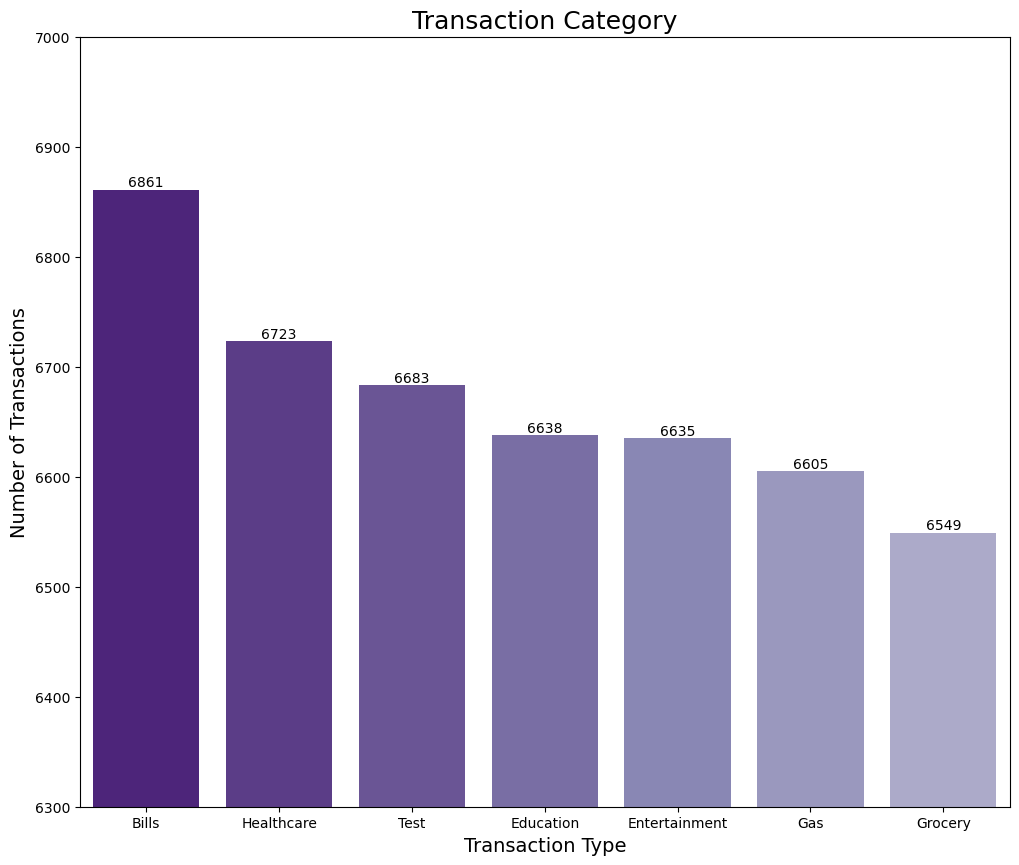

In [54]:
fig, ax = plt.subplots(figsize=(12, 10))
palette = sns.color_palette('Purples_r', 12)
ax = sns.barplot(x='categories', y='frequency', data=types_df, palette=palette)
plt.title('Transaction Category', fontsize=18)
plt.ylabel('Number of Transactions', fontsize=14)
plt.xlabel('Transaction Type', fontsize=14)
plt.ylim(6300, 7000)
ax.bar_label(ax.containers[0])
plt.savefig('./images/transaction_types_amounts.png', dpi=500); 

#### Showing customers by state

In [55]:
states = pd_customers.groupby(['CUST_STATE'])['CUST_STATE'].count()
states

CUST_STATE
AL     5
AR     5
CA    45
CT    14
FL    64
GA    73
IA    21
IL    58
IN    13
KY    17
MA    33
MD    50
MI    44
MN    28
MS    24
MT     9
NC    37
NJ    53
NY    96
OH    44
PA    72
SC    30
TX    33
VA    39
WA    16
WI    29
Name: CUST_STATE, dtype: int64

In [56]:
state_names= pd_customers.CUST_STATE.value_counts()
state_count = state_names.reset_index()
state_count.columns = ['states', 'frequency']
state_count

,states,frequency
0,NY,96
1,GA,73
2,PA,72
3,FL,64
4,IL,58
5,NJ,53
6,MD,50
7,CA,45
8,OH,44
9,MI,44


In [57]:
#chose to show the top 8 - could choose to show all 26 
top_8_states = state_count.nlargest(8, ['frequency'])
top_8_states

,states,frequency
0,NY,96
1,GA,73
2,PA,72
3,FL,64
4,IL,58
5,NJ,53
6,MD,50
7,CA,45


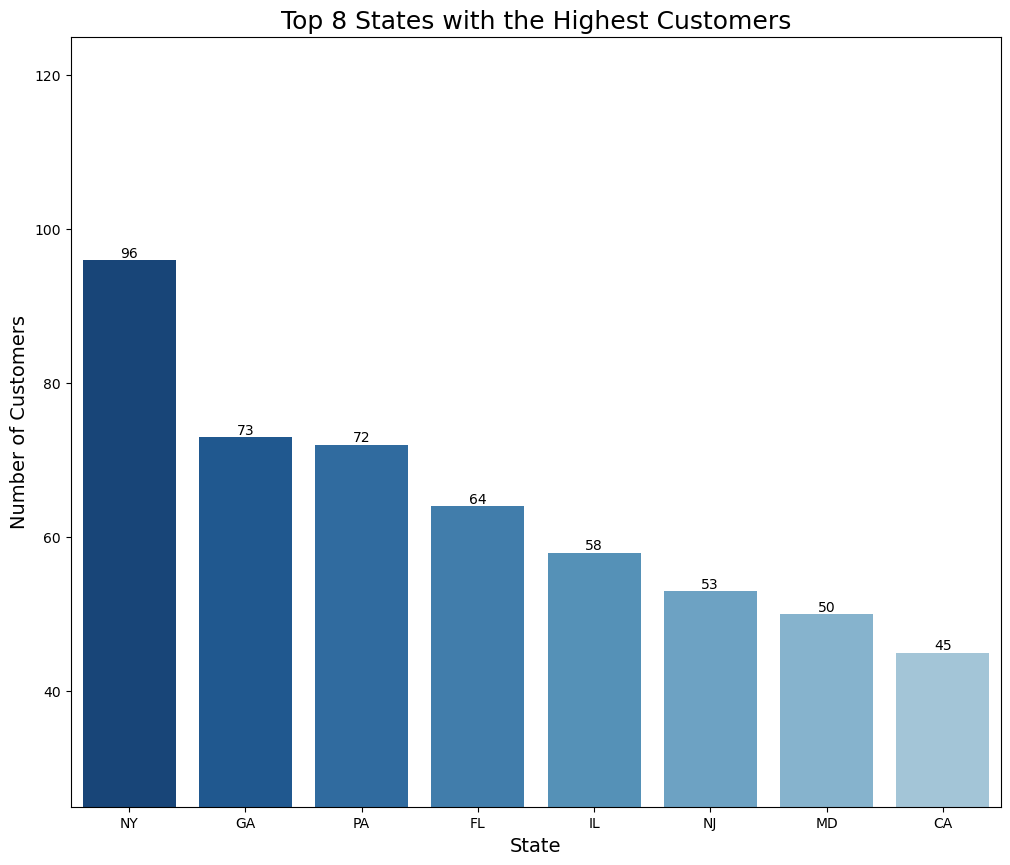

In [58]:
fig, ax = plt.subplots(figsize=(12, 10))
palette = sns.color_palette('Blues_r', 12)
ax = sns.barplot(x='states', y='frequency', data=top_8_states, palette=palette)
plt.title('Top 8 States with the Highest Customers', fontsize= 18)
plt.xlabel('State', fontsize=14)
plt.ylabel('Number of Customers', fontsize=14)
plt.ylim(25, 125)
ax.bar_label(ax.containers[0])
plt.savefig('./images/top_8_states_by_customer.png', dpi=500);

#### Transaction total by customers

In [59]:
customer_transaction = pd_credit.groupby(['CUST_SSN'])['TRANSACTION_VALUE'].sum()
customer_transaction

CUST_SSN
123451007    2037.98
123451012    4025.69
123451037    2122.20
123451041    1085.14
123451068    2810.54
              ...   
123459940      96.27
123459965    2152.70
123459968     964.21
123459978    3091.78
123459988    4760.29
Name: TRANSACTION_VALUE, Length: 952, dtype: float64

In [60]:
individual_cust = customer_transaction.reset_index()
individual_cust.sort_values(by=['TRANSACTION_VALUE'], ascending=False, inplace=True)
individual_cust

,CUST_SSN,TRANSACTION_VALUE
14,123451125,5633.07
177,123452783,5548.14
248,123453486,5476.08
814,123458668,5314.97
599,123456678,5261.03
...,...,...
493,123455652,73.59
238,123453375,73.08
873,123459201,61.67
129,123452345,10.41


In [61]:
#top customer - highest total transaction amount
biggest_spender = individual_cust.sort_values(by=['TRANSACTION_VALUE'], ascending=False).head(1)
biggest_spender

,CUST_SSN,TRANSACTION_VALUE
14,123451125,5633.07


In [62]:
#top 15 customers
top_15_customers = individual_cust.sort_values(by=['TRANSACTION_VALUE'], ascending=False).head(15)
top_15_customers

,CUST_SSN,TRANSACTION_VALUE
14,123451125,5633.07
177,123452783,5548.14
248,123453486,5476.08
814,123458668,5314.97
599,123456678,5261.03
99,123452026,5241.18
152,123452518,5223.96
414,123454933,5203.08
693,123457547,5149.75
102,123452085,5133.29


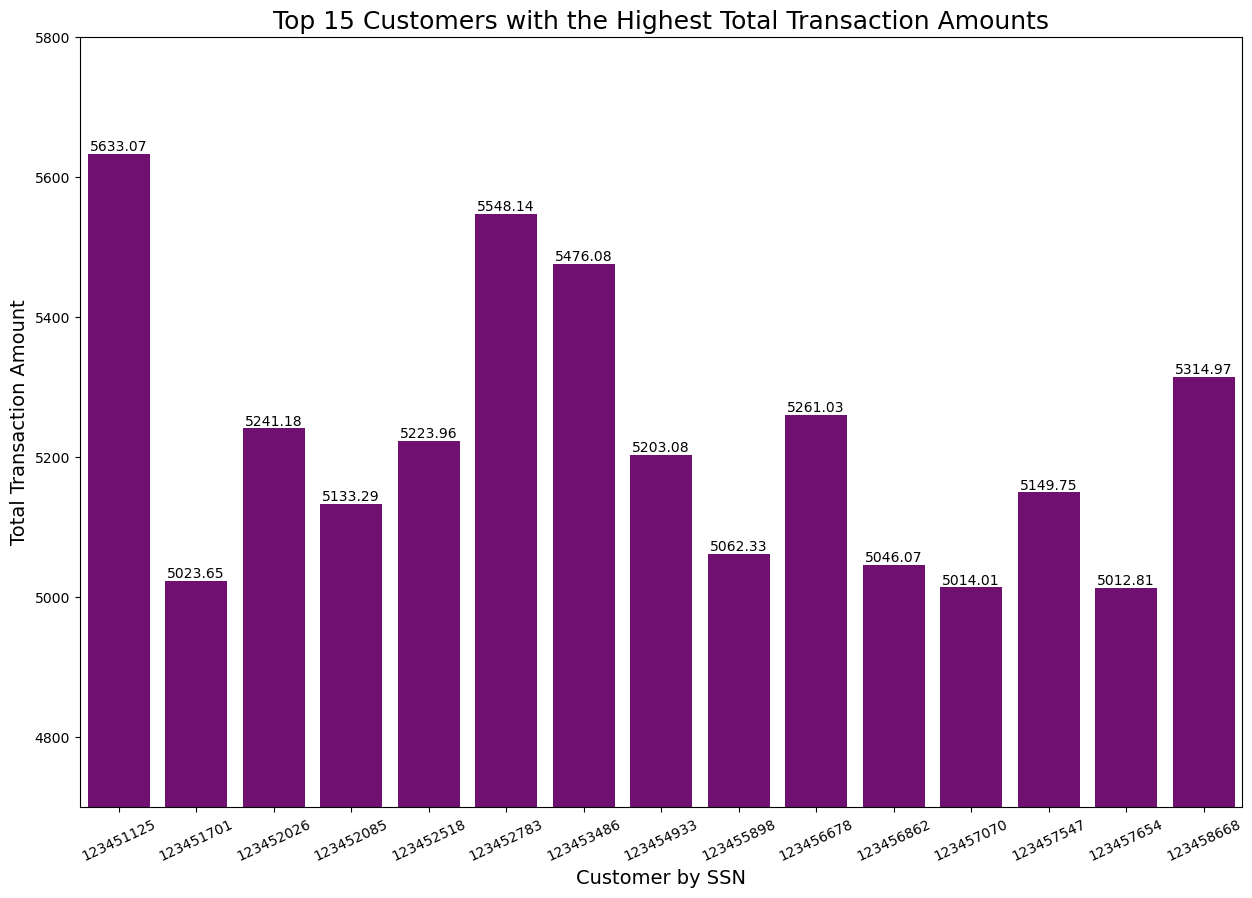

In [63]:

fig, ax = plt.subplots(figsize=(15, 10))
ax = sns.barplot(x='CUST_SSN', y='TRANSACTION_VALUE', data=top_15_customers, color='purple')
plt.title('Top 15 Customers with the Highest Total Transaction Amounts', fontsize=18)
plt.xlabel('Customer by SSN', fontsize=14)
plt.ylabel('Total Transaction Amount', fontsize=14)
plt.ylim(4700, 5800)
plt.xticks(rotation = 25)
ax.bar_label(ax.containers[0])
plt.savefig('./images/top15_customers_by_total_transaction_amounts.png', dpi=500);

In [64]:
#exporting pandas dataframes as csv files for next notebook
pd_branch.to_csv('/Users/purple/Documents/Project/Data_Engineering/Python/Capstone1/data/pd_branch.csv', index=False)
pd_credit.to_csv('/Users/purple/Documents/Project/Data_Engineering/Python/Capstone1/data/pd_credit.csv', index=False)
pd_customers.to_csv('/Users/purple/Documents/Project/Data_Engineering/Python/Capstone1/data/pd_customers.csv', index=False)
pd_branch_and_credit.to_csv('/Users/purple/Documents/Project/Data_Engineering/Python/Capstone1/data/pd_branch_and_credit.csv', index=False)
pd_cust_and_credit.to_csv('/Users/purple/Documents/Project/Data_Engineering/Python/Capstone1/data/pd_cust_and_credit.csv', index=False)

In [65]:
#stopping spark session
spark.stop()